# PARCtorch

## Normalization

In [12]:
import sys
import os

# Add the root directory (PARCTorch) to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from data.normalization import compute_min_max

In [13]:
# Example usage
data_dirs = ['/project/vil_baek/data/physics/PARCTorch/HMX/train', '/project/vil_baek/data/physics/PARCTorch/HMX/test']
output_file = '../data/hmx_min_max.json'
compute_min_max(data_dirs, output_file)

Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/qumulo/qhome/jtb3sud/PARCtorch/PARCtorch/demos
Total files to process: 134
Processed 100/134 files.
Processed 134/134 files.
Channel-wise min values: [300.0, -1186907500.0, 0.0, -1995.0012, -5521.5503]
Channel-wise max values: [5000.0, 69721220000.0, 1.0, 7184.0073, 5215.695]
Min and max values saved to '/sfs/qumulo/qhome/jtb3sud/PARCtorch/PARCtorch/data/hmx_min_max.json'.


## Create Data Loader for Training

In [14]:
# Now import the utilities
from data.dataset import GenericPhysicsDataset, custom_collate_fn, visualize_channels

import torch
from torch.utils.data import DataLoader
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s] %(message)s')

# Example configuration for HMX dataset
data_dir_train = '/project/vil_baek/data/physics/PARCTorch/HMX/train'  # Replace with your actual train directory path
data_dir_test = '/project/vil_baek/data/physics/PARCTorch/HMX/test'    # Replace with your actual test directory path
future_steps = 4
# Path to the min_max.json file
min_max_path = os.path.join('..', 'data', 'hmx_min_max.json')  # Correct path
batch_size = 8

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=future_steps,
    min_max_path=min_max_path
)

# Create DataLoader for training dataset
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

2024-10-08 12:15:38,921 [INFO] Starting data validation...
2024-10-08 12:15:38,922 [INFO] Validating .npy files...
Validating files: 100%|██████████| 100/100 [00:00<00:00, 745.58it/s]
2024-10-08 12:15:39,057 [INFO] Data validation completed successfully.
2024-10-08 12:15:39,058 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 100/100 [00:00<00:00, 874.73it/s]
2024-10-08 12:15:39,174 [INFO] Total samples in dataset: 1100


## Visualize the Data was Laoded Properly

Channel Data Statistics:
Channel 0: IC min=0.0, IC max=0.0089606624096632
  Step 1: min=0.0, max=0.1176629364490509
  Step 2: min=0.0, max=0.26262304186820984
  Step 3: min=0.0, max=0.5294193625450134
  Step 4: min=0.0, max=0.49203017354011536
Channel 1: IC min=0.016738668084144592, IC max=0.022297993302345276
  Step 1: min=0.016364343464374542, max=0.16503430902957916
  Step 2: min=0.016738668084144592, max=0.14859513938426971
  Step 3: min=0.013704854995012283, max=0.1770443618297577
  Step 4: min=0.013107223436236382, max=0.14893604815006256
Channel 2: IC min=0.0, IC max=1.0
  Step 1: min=0.0, max=1.0
  Step 2: min=0.0, max=1.0
  Step 3: min=0.0, max=1.0
  Step 4: min=0.0, max=1.0
Channel 3: IC min=0.21734386682510376, IC max=0.24943038821220398
  Step 1: min=0.21734386682510376, max=0.52634197473526
  Step 2: min=0.21734386682510376, max=0.7593672275543213
  Step 3: min=0.21734386682510376, max=0.8567501306533813
  Step 4: min=0.21734386682510376, max=0.741773784160614
Channel 4: I

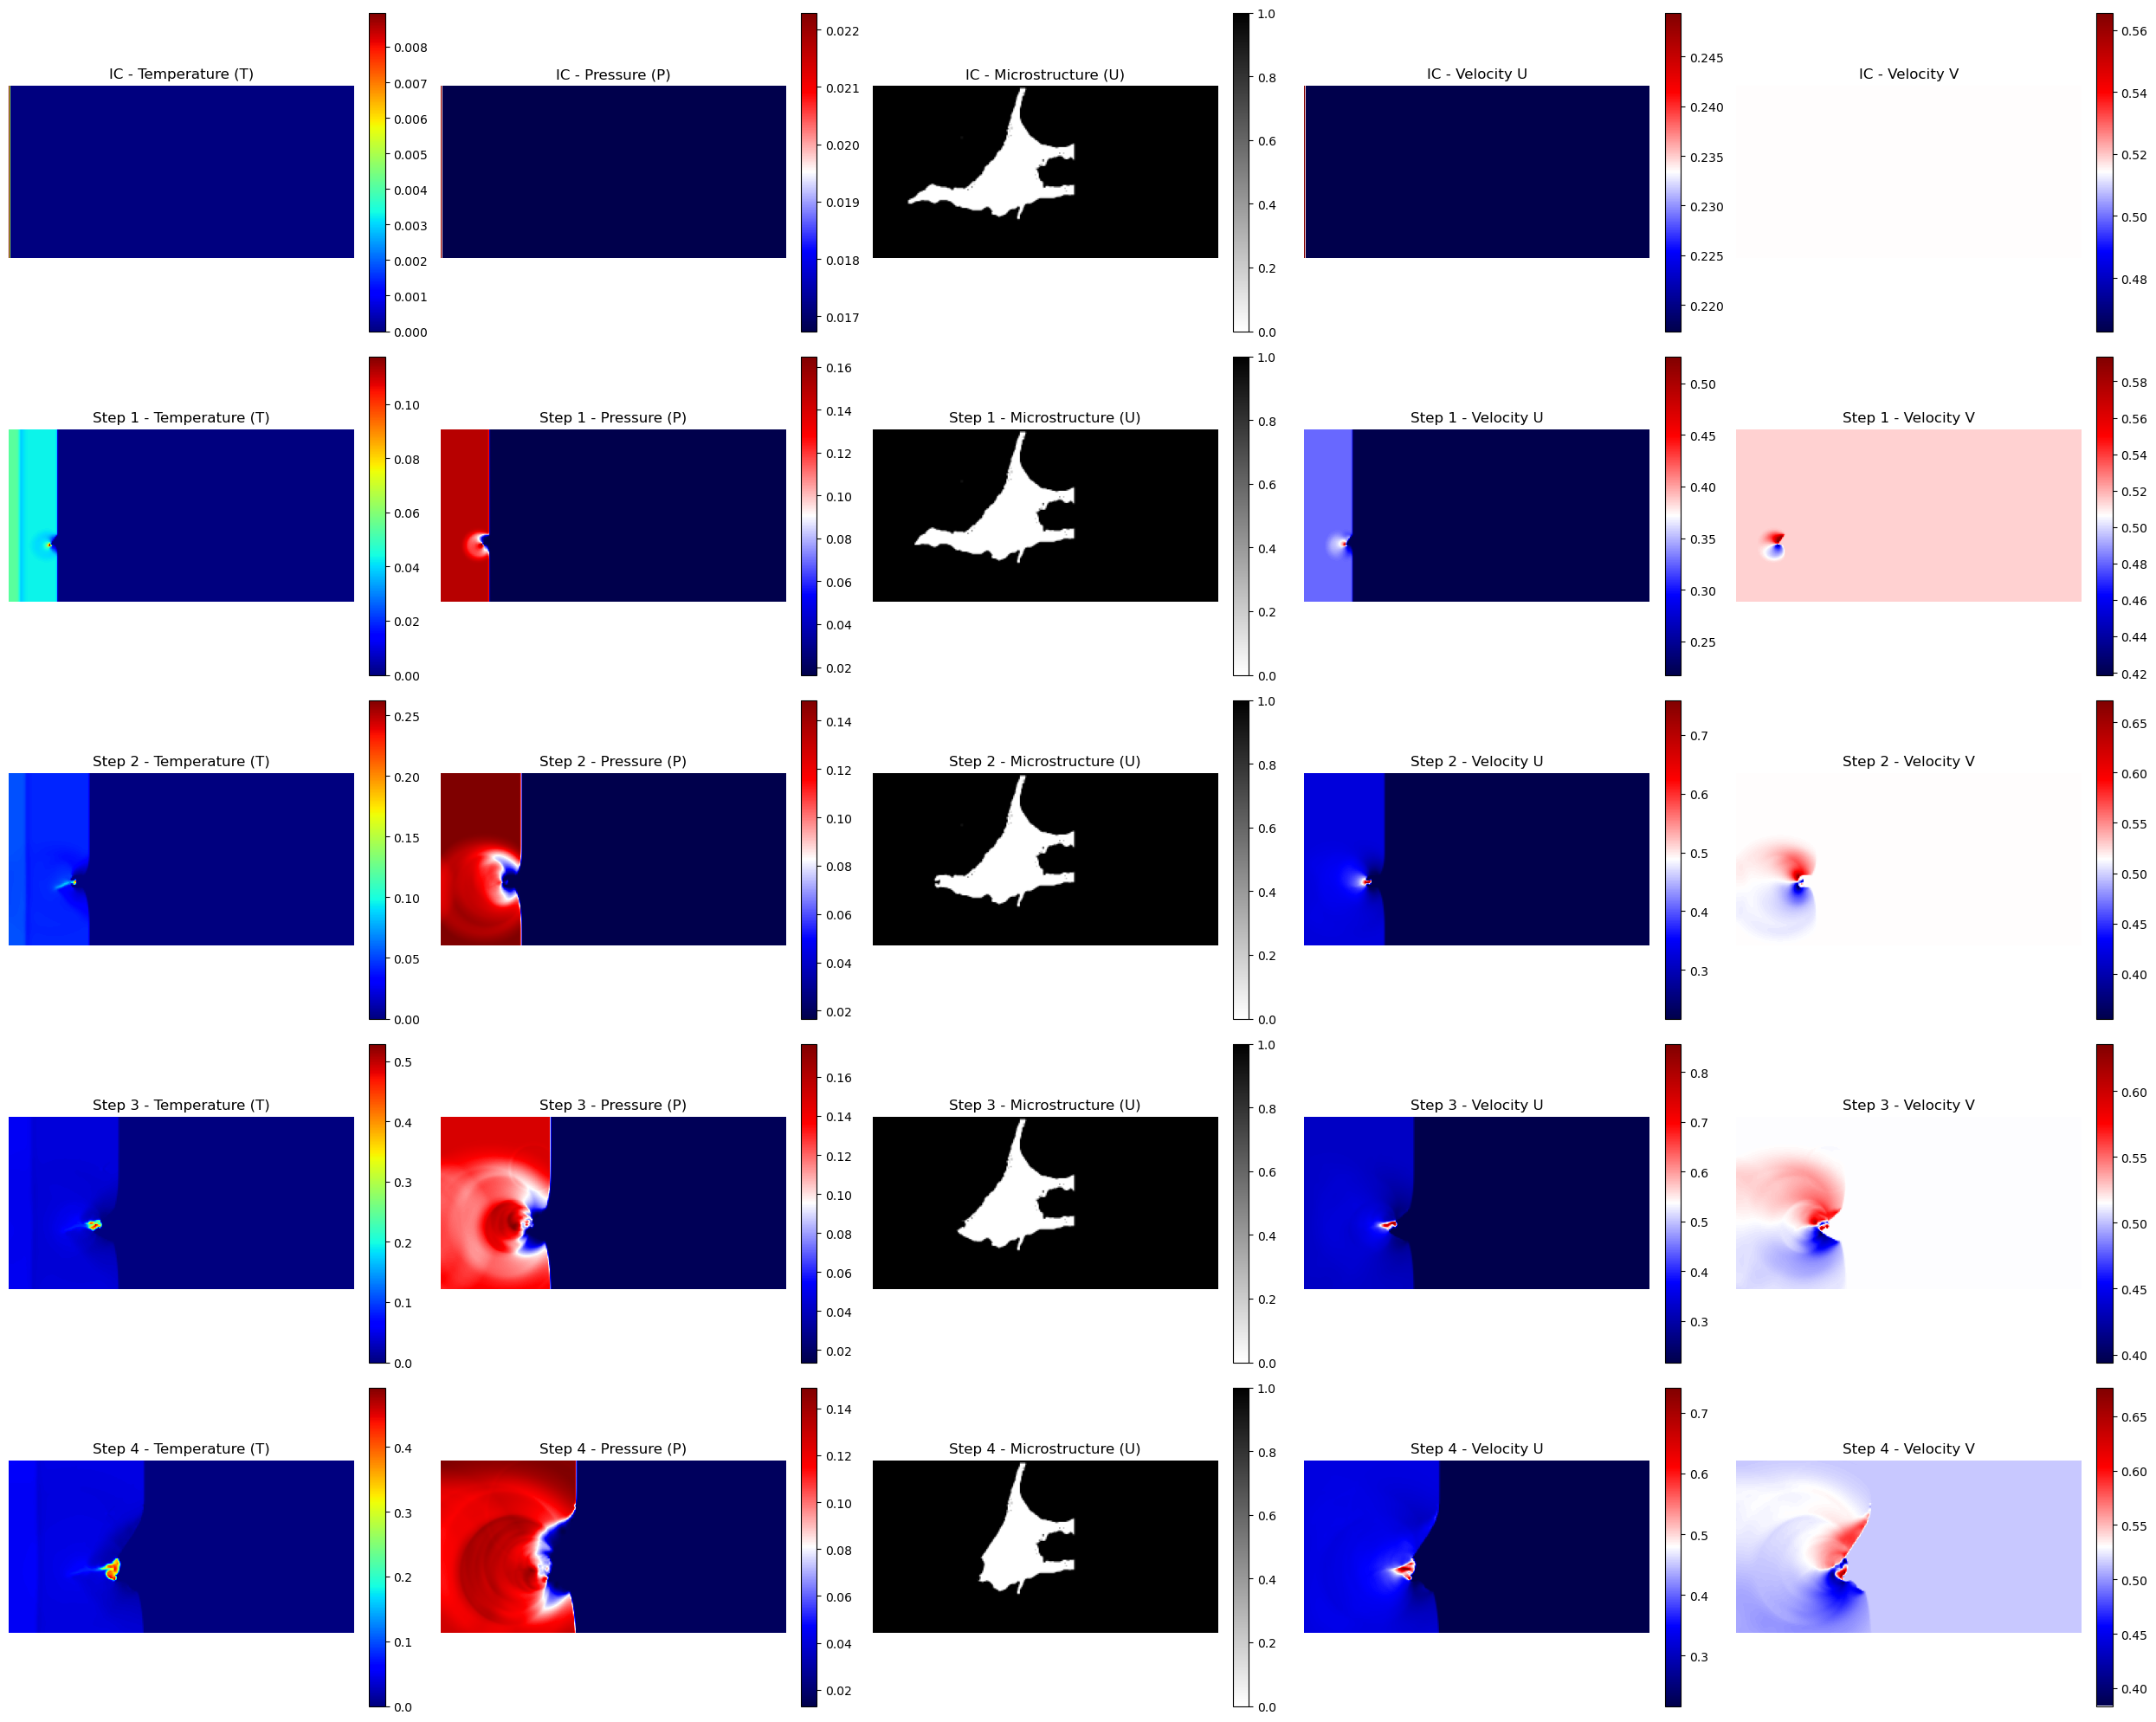

In [15]:
# Fetch a batch and visualize
for batch in train_loader:
    ic, t0, t1, target = batch
    channel_names = ['Temperature (T)','Pressure (P)', 'Microstructure (U)', 'Velocity U', 'Velocity V']
    custom_cmaps = ['jet','seismic', 'binary', 'seismic', 'seismic']

    visualize_channels(ic, t0, t1, target, channel_names=channel_names, channel_cmaps=custom_cmaps)
    break  # Visualize one batch for now

## Build your PARC Model

In [16]:
import sys
sys.path.append("../../")

In [17]:
from PARCtorch.PARCv2 import PARCv2
from PARCtorch.differentiator.differentiator import Differentiator
from PARCtorch.differentiator.finitedifference import FiniteDifference
from PARCtorch.integrator.integrator import Integrator
from PARCtorch.integrator.heun import Heun
from PARCtorch.utilities.unet import UNet

In [18]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import matplotlib.animation as animation
from torch.optim import Adam

In [30]:
# Navier Stokes: p, re, u, v
# Adv: u, v
# Dif: u, v
# Poi: p
n_fe_features = 128
unet_ns = UNet([64, 64*2, 64*4, 64*8, 64*16], 5, n_fe_features, up_block_use_concat=[False, True, False, True], skip_connection_indices=[2, 0])
right_diff = FiniteDifference(padding_mode="replicate").cuda()
heun_int = Heun().cuda()
diff_ns = Differentiator(5,                 # 3 state variables: p, re. We always assume 2 velocity being the last 2 channels 
                         n_fe_features,     # Number of features returned by the feature extraction network: 64
                         [3, 4],            # Channel indices to calculate advection: u and v
                         [3, 4],            # Channel indices to calculate diffusion: u and v
                         unet_ns,           # Feature extraction network: unet_burgers
                         "constant",        # Padding mode: constant padding of zero
                         right_diff        # Finite difference method: replication of image_gradients
                         
                        ).cuda()
ns_int = Integrator(True,                     # Clip input data between 0 and 1
                    [(0, 2, 3, 1)],           # Poisson: calculate Poisson on indices 2 (u) and 3 (v), combine it with all the input and output to index 0 (p) 
                    heun_int,                 # Heun integration
                    [None, None, None, None], # No data driven integrator
                    "constant",               # Padding mode: constant padding of zero
                    right_diff,                # Finite difference method: replication of image_gradients
                   ).cuda()
criterion = torch.nn.L1Loss().cuda()
model = PARCv2(diff_ns, ns_int, criterion).cuda()
optimizer = Adam(model.parameters(), lr=1e-5)

In [31]:
## Train the Model 

In [32]:
from tqdm import tqdm  # Import tqdm for progress bar

# Training loop with tqdm for progress bars
def train_model(model, train_loader, criterion, optimizer, num_epochs, save_dir):
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    model = model.cuda()  # Move model to GPU
    for epoch in range(1, num_epochs + 1):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Add tqdm progress bar to track the training batches
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}")
        
        for batch_idx, batch in progress_bar:
            # Assuming batch contains ic, t0, t1, and ground truth (gt)
            ic, t0, t1, gt = batch  # Unpack the batch tuple

            # Move data to GPU
            ic = ic.cuda()
            t0 = t0.cuda()
            t1 = t1.cuda()
            gt = gt.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            predictions = model(ic, t0, t1)

            # Compute loss
            loss = criterion(predictions[:, :, 1:, :, :], gt[:, :, 1:, :, :])

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate running loss
            running_loss += loss.item()
            
            # Update tqdm progress bar with current loss
            progress_bar.set_postfix({"Batch Loss": loss.item()})

        # Calculate and print average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch}/{num_epochs}], Average Loss: {epoch_loss:.4f}")

        # Save the model weights at the end of the epoch
        model_save_path = os.path.join(save_dir, f"model.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"Model weights saved at {model_save_path}")

# Example usage:
train_model(model, train_loader, criterion, optimizer, num_epochs=10, save_dir='/sfs/qumulo/qhome/jtb3sud/hold/testnavier_stokes')


Epoch 1/10:   0%|          | 0/138 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (5) must match the size of tensor b (7) at non-singleton dimension 1

## Load the Model

In [ ]:
# Define the testing function
def test_model(model, test_loader, criterion, save_dir, model_filename='model.pth', device=None):
    """
    Loads a trained model and evaluates it on the test dataset.
    
    Args:
        model (nn.Module): The PyTorch model architecture to be loaded.
        test_loader (DataLoader): DataLoader for the test data.
        criterion (nn.Module): Loss function.
        save_dir (str): Directory where the saved model checkpoint is located.
        model_filename (str, optional): Filename of the saved model. Defaults to 'model.pth'.
        device (torch.device, optional): Device to run the evaluation on. If None, automatically detects.
    
    Returns:
        float: Average loss over the test dataset.
        dict: Dictionary containing other evaluation metrics.
    """
    # Set device
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Load the saved model weights
    model_path = os.path.join(save_dir, model_filename)
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Loaded model weights from {model_path}")
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize variables to track loss and metrics
    total_loss = 0.0
    total_samples = 0
    metrics = {}  # Example: {'accuracy': 0.0}
    
    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Initialize tqdm progress bar for testing
        progress_bar = tqdm(enumerate(test_loader), 
                            total=len(test_loader), 
                            desc="Testing", 
                            unit="batch")
        
        for batch_idx, batch in progress_bar:
            # Assuming batch contains ic, t0, t1, and ground truth (gt)
            ic, t0, t1, gt = batch  # Unpack the batch tuple

            # Move data to the appropriate device
            ic = ic.to(device)
            t0 = t0.to(device)
            t1 = t1.to(device)
            gt = gt.to(device)

            # Forward pass
            predictions = model(ic, t0, t1)

            # Compute loss
            loss = criterion(predictions[:, :, 1:, :, :], gt[:, :, 1:, :, :])

            # Accumulate loss
            batch_size = ic.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            # Example Metric: Compute accuracy (modify as per your task)
            # Assuming a classification task; adjust accordingly
            # _, predicted = torch.max(predictions, 1)
            # _, labels = torch.max(gt, 1)
            # correct = (predicted == labels).sum().item()
            # metrics['accuracy'] = metrics.get('accuracy', 0.0) + correct

            # Update tqdm progress bar with current loss
            progress_bar.set_postfix({"Batch Loss": loss.item()})
    
    # Calculate average loss
    average_loss = total_loss / total_samples
    print(f"\nTest Loss: {average_loss:.4f}")
    
    # Calculate and print other metrics
    # Example:
    # average_accuracy = metrics['accuracy'] / total_samples
    # print(f"Test Accuracy: {average_accuracy:.2f}%")
    
    return average_loss, metrics

## Create the Test Loader

In [ ]:
# Initialize the dataset
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path
)

# Create DataLoader for training dataset
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

In [ ]:
test_model(model, test_loader, criterion, save_dir='/sfs/qumulo/qhome/jtb3sud/hold/testnavier_stokes')